#  **Credit Card Fraud Detection**  
## Model Selection Framework Under Extreme Class Imbalance  
 
**Objective:** Compare supervised and unsupervised methods for fraud detection  
**Dataset:** Credit Card Transactions (PCA-transformed features)  

---

###  Problem Statement

Credit card fraud detection suffers from extreme class imbalance (~0.17% fraud rate).  
Traditional accuracy metrics are misleading.

This project evaluates:

- Random Forest (Supervised)
- Isolation Forest (Unsupervised)
- Local Outlier Factor (Unsupervised)
- DBSCAN (Clustering)

Evaluation focuses on:
- Recall
- Precision
- F1 Score
- ROC-AUC
- Precision-Recall AUC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##  **Dataset Overview**

- Total transactions: 284,807  
- Fraud cases: 492  
- Fraud percentage: ~0.17%  
- Features: PCA-transformed (V1–V28), Time, Amount  
- Target: Class (0 = Normal, 1 = Fraud)

Class
0    284315
1       492
Name: count, dtype: int64

Fraud Percentage: 0.1727485630620034


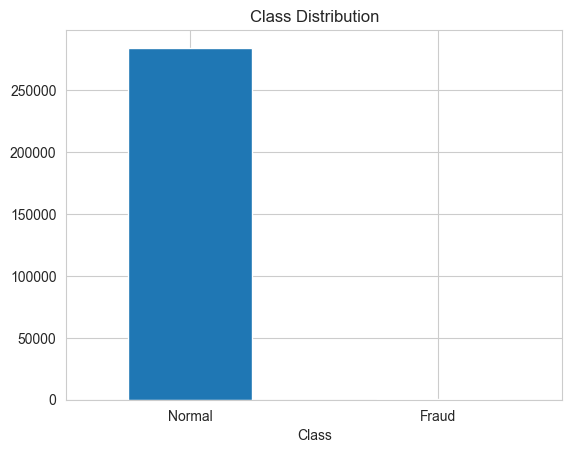

In [3]:
print(df["Class"].value_counts())
print("\nFraud Percentage:", df["Class"].mean() * 100)

plt.figure()
df["Class"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xticks([0,1], ["Normal","Fraud"], rotation=0)
plt.show()

In [4]:
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (227845, 30)
Test shape: (56962, 30)


##  **Why Accuracy is Misleading**

If a model predicts every transaction as "Normal":

Accuracy ≈ 99.83%

But:
- Recall for fraud = 0
- Fraud not detected at all

Therefore, evaluation must focus on:
- Recall
- Precision
- PR-AUC

## **RANDOM FOREST MODEL**

In [5]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## **CONFUSION MATRIX**

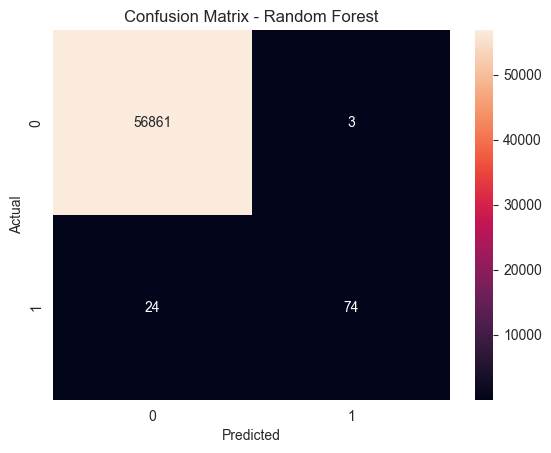

In [6]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **ROC CURVE**

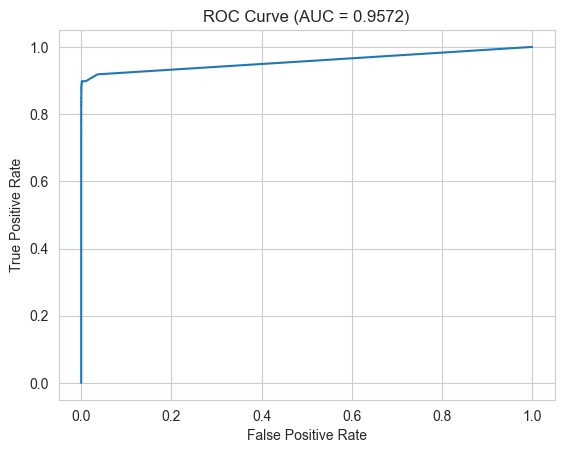

ROC-AUC: 0.9571962964983404


In [7]:
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("ROC-AUC:", roc_auc)

## **PRECISION-RECALL CURVE**

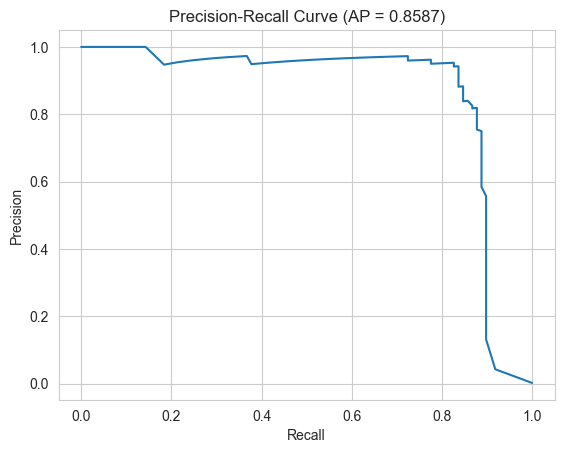

Average Precision (PR-AUC): 0.8587164168870633


In [8]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
ap_score = average_precision_score(y_test, y_prob_rf)

plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AP = {ap_score:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("Average Precision (PR-AUC):", ap_score)

## **FEATURE IMPORTANCE**

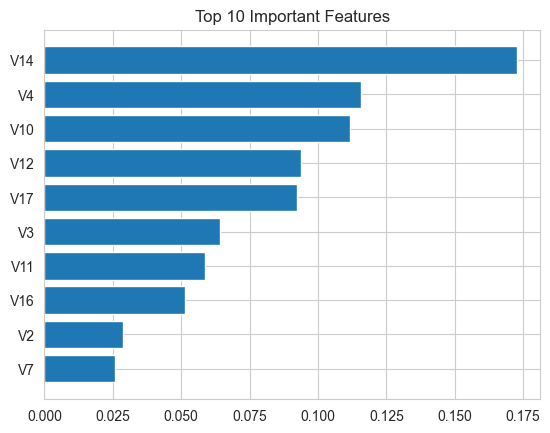

In [9]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure()
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), np.array(df.columns[:-1])[indices])
plt.title("Top 10 Important Features")
plt.show()

## **ISOLATION FOREST**

In [10]:
iso = IsolationForest(
    contamination=df["Class"].mean(),
    random_state=42
)

iso.fit(X_train)

y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("Isolation Forest Results:\n")
print(classification_report(y_test, y_pred_iso))

Isolation Forest Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.34      0.32        98

    accuracy                           1.00     56962
   macro avg       0.65      0.67      0.66     56962
weighted avg       1.00      1.00      1.00     56962



## **LOCAL OUTLIER FACTOR**

In [11]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=df["Class"].mean()
)

y_pred_lof = lof.fit_predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

print("Local Outlier Factor Results:\n")
print(classification_report(y_test, y_pred_lof))

Local Outlier Factor Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.02      0.02      0.02        98

    accuracy                           1.00     56962
   macro avg       0.51      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962



## **DBSCAN**

In [12]:
dbscan = DBSCAN(eps=3, min_samples=10)
y_pred_db = dbscan.fit_predict(X_test)
y_pred_db = np.where(y_pred_db == -1, 1, 0)

print("DBSCAN Results:\n")
print(classification_report(y_test, y_pred_db))

DBSCAN Results:

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.90      0.02        98

    accuracy                           0.87     56962
   macro avg       0.51      0.88      0.48     56962
weighted avg       1.00      0.87      0.93     56962



## **MODEL COMPARISON**

##  Model Comparison Summary

After running all models, compare:

- Fraud Recall
- Fraud Precision
- F1 Score
- PR-AUC

Expected Insight:

- Random Forest → Best performance (because labels exist)  
- Isolation Forest → Moderate detection  
- LOF / DBSCAN → Weak for this structured dataset  

---

###  Final Decision

When labeled data exists → Supervised learning is superior.

Fraud detection is a cost-sensitive classification problem,
not purely an anomaly detection task.

#  Final Conclusion

Key Takeaways:

- Accuracy is misleading in imbalanced datasets.
- Recall and Precision-Recall AUC are critical.
- Random Forest significantly outperforms unsupervised methods.
- Supervised models should be prioritized when labeled fraud data exists.
- Model choice must align with business cost considerations.

This project demonstrates structured model evaluation under extreme class imbalance.